# Adding Human-in-the-Loop Functionality to the Agent: Ask for Approval

In this tutorial, we will enhance our chatbot agent by integrating a human-in-the-loop step before calling a tool. 

Be sure to have completed the previous tutorials in this module before proceeding, as we will be building on top of the earlier code. For simplicity, we'll only be using the Tavily search tool in this tutorial, and skip the date tool to keep things simple.



### Imports
We start by importing the necessary libraries:

In [1]:
from langchain_openai import ChatOpenAI
from langchain_community.tools import TavilySearchResults
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

from typing import Annotated
from typing_extensions import TypedDict

from dotenv import load_dotenv
_ = load_dotenv()

### Setup and Configuration
We define the model, tools, and the graph structure.


In [2]:
# defining the model
llm = ChatOpenAI(model="gpt-4o")

# defining the search tool
tavily_search = TavilySearchResults(max_results=2)

# list of tools for the agent
tools = [tavily_search]

# binding tools to the llm
llm_with_tools = llm.bind_tools(tools)

# defining the stategraph
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# defining the nodes
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# defining the edges
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

### Setting up Human-in-the-Loop

We set up checkpointing for the conversation state and compile the graph with interruption before calling any tools. This allows the agent to get an approval from humans before proceeding.


In [3]:
# Setting up checkpointing for conversation state
memory = MemorySaver()

# Compiling the graph with human-in-the-loop interruption
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"]  # Interrupt before executing tools
)

### Visualizing the Chatbot's Workflow
We can visualize the chatbot's workflow using LangGraph's graph visualization tools. We'll notice that there's an interruption mechanism in the tool call.


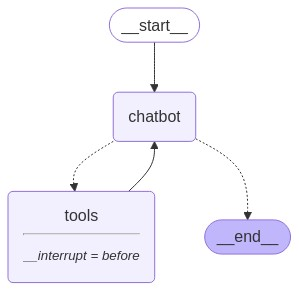

In [4]:
from IPython.display import display, Image

# Visualize the chatbot's workflow
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass  # Visualization requires additional dependencies

### Testing the Human-in-the-Loop Functionality
Let's test the chatbot with a query that requires tool usage:

In [5]:
user_input = "What is the weather in Tokyo?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the weather in Tokyo?


python(64806) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_SZJkjsVDs8vdILhaN5VxkZwB)
 Call ID: call_SZJkjsVDs8vdILhaN5VxkZwB
  Args:
    query: current weather in Tokyo


As we can see in the above output, the chatbot attempts to use a tool to fetch information, but before executing the tool, it interrupts and waits for human input.

### Handling the Interruption
At this point, the chatbot has paused before executing the tool. As a human operator, you can inspect the pending tool call and decide whether to proceed, modify the input, or halt. For this tutorial, we'll only focus on approving the tool call.

### Inspecting the State of the Graph

We can inspect the state of the graph to see the pending tool call, by getting the snapshot of the current state, we'll find the next node that the graph is supposed to transition to is the tools node.



In [6]:
# Get the current state
snapshot = graph.get_state(config)
print(snapshot.next)

('tools',)


Inspecting the tool calls in the last message, we can see the arguments that will be passed to the tool.

In [7]:
# Inspect the tool calls
last_message = snapshot.values["messages"][-1]
print(last_message.tool_calls)

[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Tokyo'}, 'id': 'call_SZJkjsVDs8vdILhaN5VxkZwB', 'type': 'tool_call'}]


### Continuing the Conversation
To continue the conversation without modifying the state, simply invoke the graph with None as the input:



In [8]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_SZJkjsVDs8vdILhaN5VxkZwB)
 Call ID: call_SZJkjsVDs8vdILhaN5VxkZwB
  Args:
    query: current weather in Tokyo
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Tokyo', 'region': 'Tokyo', 'country': 'Japan', 'lat': 35.6895, 'lon': 139.6917, 'tz_id': 'Asia/Tokyo', 'localtime_epoch': 1743763811, 'localtime': '2025-04-04 19:50'}, 'current': {'last_updated_epoch': 1743763500, 'last_updated': '2025-04-04 19:45', 'temp_c': 13.1, 'temp_f': 55.6, 'is_day': 0, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/night/116.png', 'code': 1003}, 'wind_mph': 5.1, 'wind_kph': 8.3, 'wind_degree': 325, 'wind_dir': 'NW', 'pressure_mb': 1015.0, 'pressure_in': 29.97, 'precip_mm': 0.03, 'precip_in': 0.0, 'humidity

### Conclusion

Congratulations! You've enhanced your support chatbot with human-in-the-loop functionality, allowing it to ask for approval before calling a tool.
